In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from datetime import datetime as dt
from copy import deepcopy
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import torch.nn as nn
import torch.nn.functional as f
from torch import optim

import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from attacks import fgsm, pgd
from model import SmallIntervalNet
from layers import *

1.7.0
True


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches


def plot_boundaries(model, data_X, data_y, low, high, points=None, r=0):
    XX, YY = np.meshgrid(np.linspace(low, high, 100), np.linspace(low, high, 100))
    X0 = torch.Tensor([XX.ravel(), YY.ravel()]).T
    ZZ = model(X0.to(device)).argmax(dim=1).view(XX.shape)
    ZZ = ZZ.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.contourf(XX, YY, ZZ, cmap="coolwarm", levels=np.linspace(-1000, 1000, 3))
    ax.scatter(data_X[:,0], data_X[:,1], c=data_y, cmap="coolwarm", s=35)
    
    torch.cuda.empty_cache()
    del ZZ
    del XX
    del YY
    del X0

    if points is not None:
        for a in points:
            ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
    plt.show()

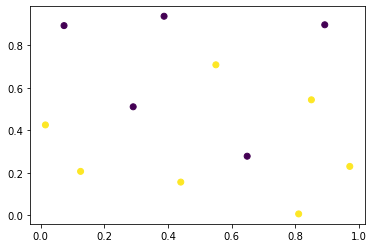

In [5]:
# random points at least 2r apart

m = 12
np.random.seed(3)
low, high = 0, 1
points = [np.random.uniform(low, high, size=(2))]
r = 0.16
while(len(points) < m):
    p = np.random.uniform(low, high, size=(2))
    if min(np.abs(p-a).sum() for a in points) > 2*r:
        points.append(p)
        
epsilon = r/2

data_X = np.array(points)
data_y = np.array([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1])

X = torch.from_numpy(data_X)
y = torch.from_numpy(data_y)
X, y = X.to(device), y.to(device)

plt.scatter(data_X[:,0], data_X[:,1], c=data_y)
plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(4)

net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

net = net.to(device)


opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(5000):
    out = net(X.float())
    loss = nn.CrossEntropyLoss()(out, y)
    err = (out.argmax(dim=1) != y).float().mean()
    if i % 1000 == 0:
        print(f"Loss: {loss.item():.2f}, Err: {err:.2f}")
    opt.zero_grad()
    loss.backward()
    opt.step()

Loss: 0.68, Err: 0.42
Loss: 0.21, Err: 0.08
Loss: 0.07, Err: 0.00
Loss: 0.03, Err: 0.00
Loss: 0.01, Err: 0.00


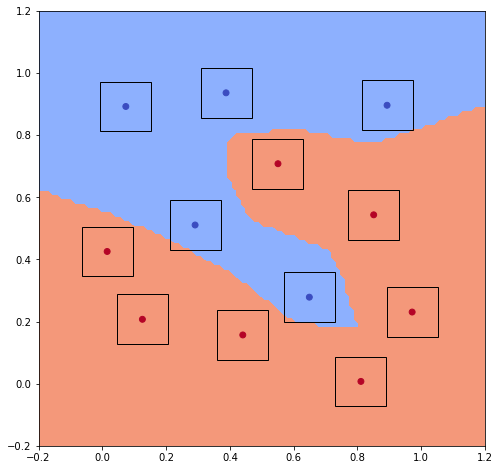

In [13]:
plot_boundaries(net, data_X, data_y, low-0.1, high+0.1, points, r)

In [47]:
torch.manual_seed(4)

robust_net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,2)
)
robust_net = robust_net.to(device)
opt = optim.Adam(robust_net.parameters(), lr=1e-3)
X_pt, y_pt = X.float(), y

W1, b1 = robust_net[0].weight, robust_net[0].bias
W2, b2 = robust_net[2].weight, robust_net[2].bias

W1, b1 = W1.to(device), b1.to(device)
W2, b2 = W2.to(device), b2.to(device)

In [48]:
def bounds_pt(X, net, epsilon): 
    X2 = f.linear(X, W1, bias=b1)
    l,u = X2 - epsilon*W1.abs().sum(1), X2 + epsilon*W1.abs().sum(1)
    return torch.clamp(l, max=0), torch.clamp(u, min=0)

class DualNet(nn.Module): 
    def forward(self, c, l, u): 
        nu3 = -c
        nu2hat = f.linear(nu3, W2.t())
        nu2 = u/(u-l)*nu2hat
        nu1 = f.linear(nu2, W1.t())
        return (nu1,nu2,nu3)

dualnet = DualNet().cuda()

def bdot(X,Y): 
    return torch.matmul(X.unsqueeze(-2),Y.unsqueeze(-1)).squeeze(-1).squeeze(-1)

def J(nu1, nu2, nu3, l): 
    return (- bdot(nu1, X_pt) - epsilon*nu1.abs().sum(-1)- bdot(nu2, b1) 
            + (l*torch.clamp(nu2,min=0)*I.float()).sum(-1) - bdot(nu3,b2))

In [49]:
k = 1
eps = r*3/4

min_loss = np.inf

for i in range(400001):
    
    # Compute upper and lower bounds
    l,u = bounds_pt(X_pt, robust_net, eps)
    I = (u > 0)*(l < 0)
    
    # Pass through dual network
    c = torch.eye(2)[y_pt]*2-1
    c = c.to(device)
    nu1, nu2, nu3 = dualnet(c, l, u)
    
    # Compute objective and loss
    dual_obj = J(nu1, nu2, nu3, l).to(device)
    loss = nn.CrossEntropyLoss()(-dual_obj.unsqueeze(-1)*(torch.eye(2)[~y]).to(device), y_pt.to(device))
    
    # Compute error and robust error
    out = robust_net(X.float())
    err = (out.argmax(1) != y_pt).float().mean()
    robust_err = (dual_obj < 0).float().mean()
    
    fit_loss = nn.CrossEntropyLoss()(out, y_pt)
    
    comined_loss = k * fit_loss + (1 - k) * loss
        
    if k >= 0.5:
        k -= 0.00005
    else:
        k=0.5
    
    if i % 1000 == 0:
        print(f"iteration: {i}")
        print(f"kappa: {k:.4f}, epsilon: {eps:.4f}")
        o = "loss: {:.4f}, error: {:.4f}, robust err: {:.4f}"
        print(o.format(comined_loss.item(), err.item(), robust_err.item()), end="\n\n")

    opt.zero_grad()
    comined_loss.backward()
    opt.step()
     

iteration: 0
kappa: 1.0000, epsilon: 0.1200
loss: 0.6827, error: 0.4167, robust err: 0.5833

iteration: 1000
kappa: 0.9500, epsilon: 0.1200
loss: 0.2342, error: 0.0833, robust err: 0.3333

iteration: 2000
kappa: 0.9000, epsilon: 0.1200
loss: 0.1536, error: 0.0000, robust err: 0.3333

iteration: 3000
kappa: 0.8500, epsilon: 0.1200
loss: 0.1405, error: 0.0000, robust err: 0.2500

iteration: 4000
kappa: 0.8000, epsilon: 0.1200
loss: 0.1577, error: 0.0000, robust err: 0.2500

iteration: 5000
kappa: 0.7500, epsilon: 0.1200
loss: 0.1734, error: 0.0000, robust err: 0.2500

iteration: 6000
kappa: 0.7000, epsilon: 0.1200
loss: 0.1917, error: 0.0000, robust err: 0.2500

iteration: 7000
kappa: 0.6500, epsilon: 0.1200
loss: 0.2113, error: 0.0000, robust err: 0.2500

iteration: 8000
kappa: 0.6000, epsilon: 0.1200
loss: 0.2308, error: 0.0000, robust err: 0.2500

iteration: 9000
kappa: 0.5500, epsilon: 0.1200
loss: 0.2487, error: 0.0000, robust err: 0.2500

iteration: 10000
kappa: 0.5000, epsilon: 0.

iteration: 85000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1440, error: 0.0000, robust err: 0.1667

iteration: 86000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1435, error: 0.0000, robust err: 0.1667

iteration: 87000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1432, error: 0.0000, robust err: 0.1667

iteration: 88000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1426, error: 0.0000, robust err: 0.1667

iteration: 89000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1427, error: 0.0000, robust err: 0.1667

iteration: 90000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1422, error: 0.0000, robust err: 0.1667

iteration: 91000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1418, error: 0.0000, robust err: 0.1667

iteration: 92000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1419, error: 0.0000, robust err: 0.1667

iteration: 93000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1415, error: 0.0000, robust err: 0.1667

iteration: 94000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1412, error: 0.0000, robust err: 0.1667

iteration: 95000
kappa: 0.5000

iteration: 169000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1193, error: 0.0000, robust err: 0.1667

iteration: 170000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1190, error: 0.0000, robust err: 0.1667

iteration: 171000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1188, error: 0.0000, robust err: 0.1667

iteration: 172000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1190, error: 0.0000, robust err: 0.1667

iteration: 173000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1189, error: 0.0000, robust err: 0.1667

iteration: 174000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1183, error: 0.0000, robust err: 0.1667

iteration: 175000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1177, error: 0.0000, robust err: 0.1667

iteration: 176000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1176, error: 0.0000, robust err: 0.1667

iteration: 177000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1169, error: 0.0000, robust err: 0.1667

iteration: 193000
kappa: 0.5000, epsilon: 0.1200
loss: 0.1117, error: 0.0000, robust err: 0.1667

iteration: 194000
ka

iteration: 268000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0699, error: 0.0000, robust err: 0.0833

iteration: 269000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0697, error: 0.0000, robust err: 0.0833

iteration: 270000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0696, error: 0.0000, robust err: 0.0833

iteration: 271000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0693, error: 0.0000, robust err: 0.0833

iteration: 272000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0692, error: 0.0000, robust err: 0.0833

iteration: 273000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0694, error: 0.0000, robust err: 0.0833

iteration: 274000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0689, error: 0.0000, robust err: 0.0833

iteration: 275000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0684, error: 0.0000, robust err: 0.0833

iteration: 276000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0687, error: 0.0000, robust err: 0.0833

iteration: 277000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0685, error: 0.0000, robust err: 0.0833

iteration: 278000
ka

iteration: 352000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0493, error: 0.0000, robust err: 0.0000

iteration: 353000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0493, error: 0.0000, robust err: 0.0000

iteration: 354000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0490, error: 0.0000, robust err: 0.0000

iteration: 355000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0485, error: 0.0000, robust err: 0.0000

iteration: 356000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0487, error: 0.0000, robust err: 0.0000

iteration: 357000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0485, error: 0.0000, robust err: 0.0000

iteration: 358000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0482, error: 0.0000, robust err: 0.0000

iteration: 359000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0482, error: 0.0000, robust err: 0.0000

iteration: 360000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0478, error: 0.0000, robust err: 0.0000

iteration: 361000
kappa: 0.5000, epsilon: 0.1200
loss: 0.0477, error: 0.0000, robust err: 0.0000

iteration: 362000
ka

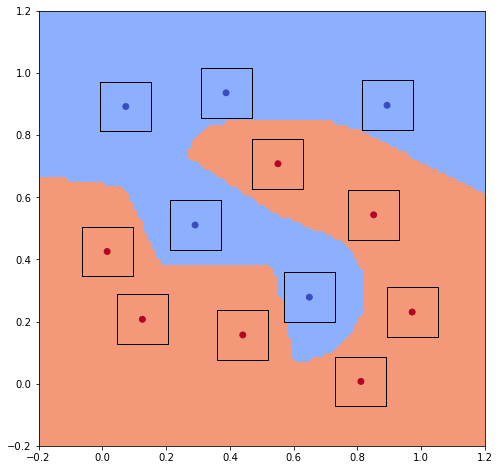

In [50]:
plot_boundaries(robust_net, data_X, data_y, low-0.2, high+0.2, points, r)

## Boundaries fo lower weight of net

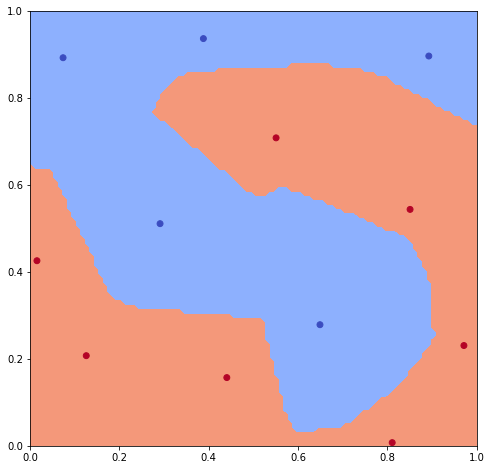

In [53]:
lower_net = deepcopy(robust_net)

for layer in lower_net:
    if isinstance(layer, nn.Linear):
        layer.weight.data -= eps
        
plot_boundaries(lower_net, data_X, data_y, low, high)

## Boundaries fo upper weight of net

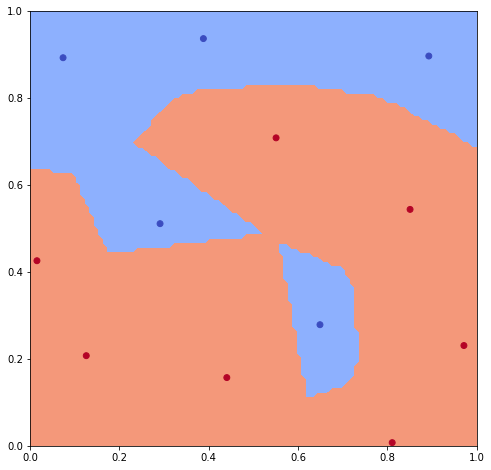

In [54]:
upper_net = deepcopy(robust_net)

for layer in upper_net:
    if isinstance(layer, nn.Linear):
        layer.weight.data += eps
        
plot_boundaries(upper_net, data_X, data_y, low, high)

## Boundaries fo random weight from interval for robust model

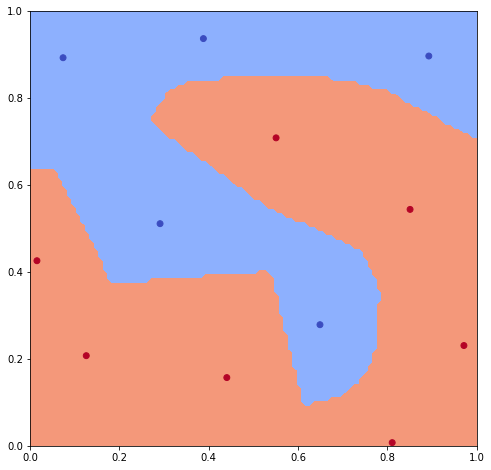

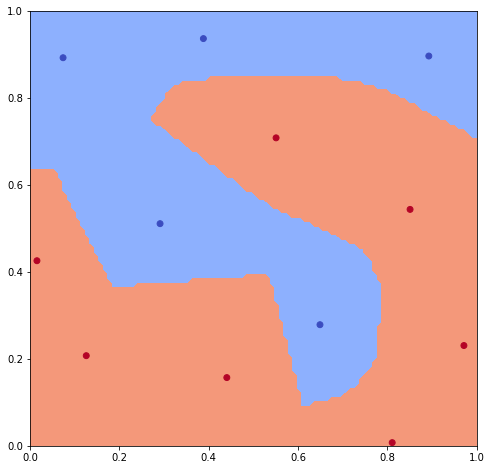

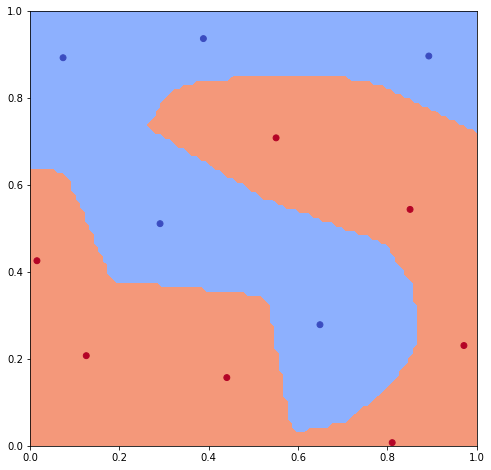

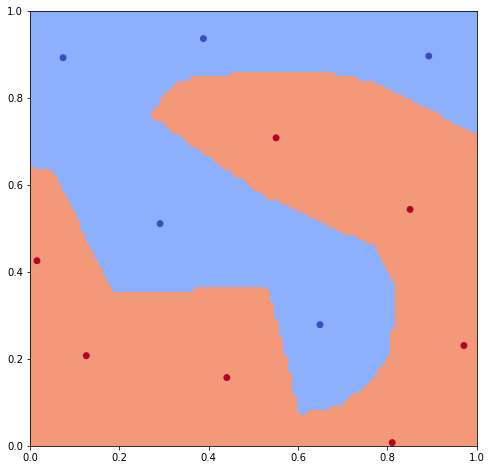

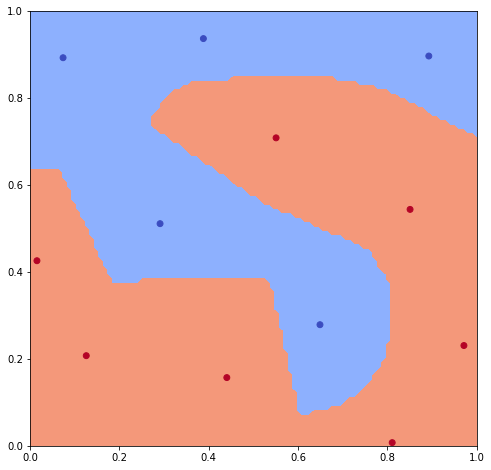

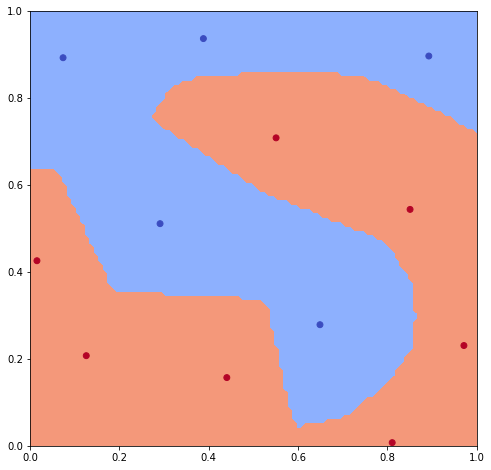

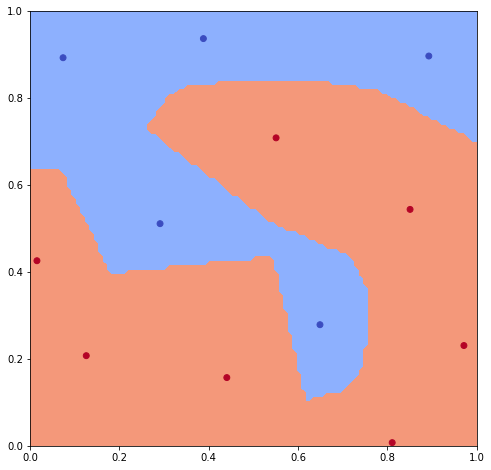

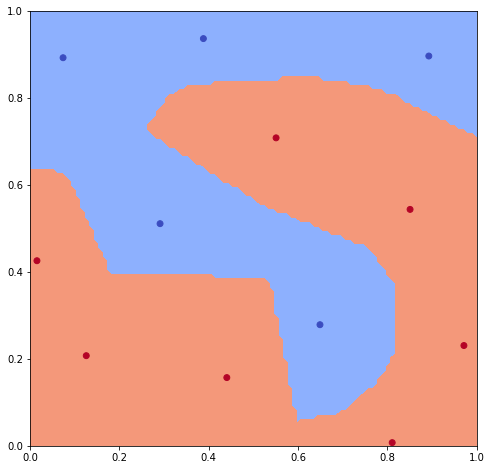

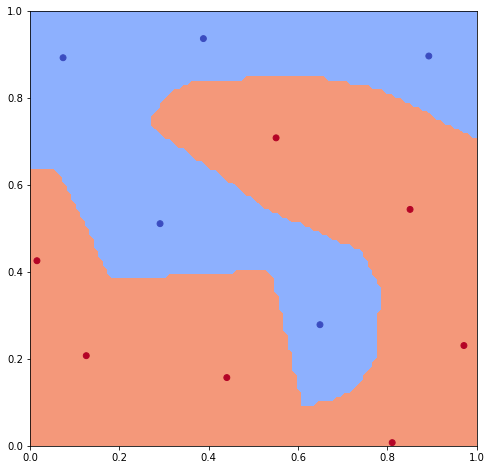

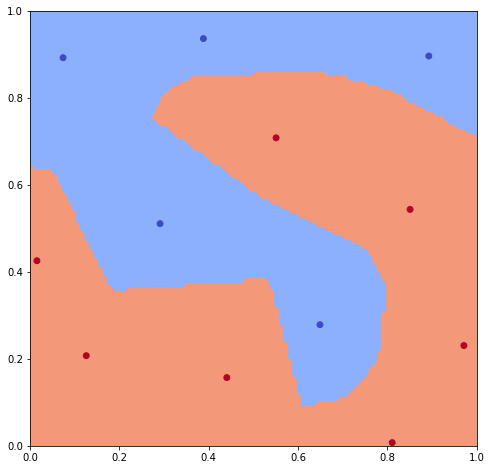

In [55]:
for _ in range(10):
    random_net = deepcopy(robust_net)

    for layer in random_net:
        if isinstance(layer, nn.Linear):
            we = torch.from_numpy(np.random.uniform(-eps, eps, layer.weight.data.size(1)))
            we = we.to(device)
            layer.weight.data += we

    plot_boundaries(random_net, data_X, data_y, low, high)

## ordinary model

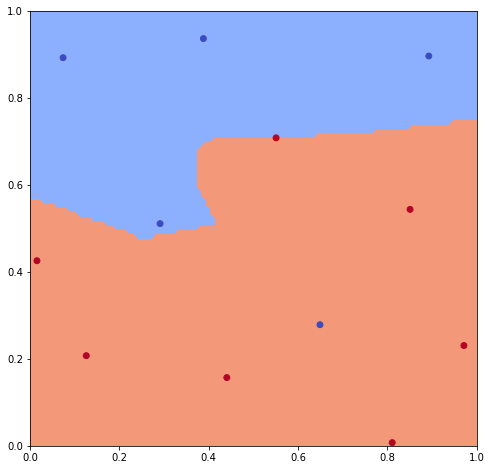

In [61]:
upper_net = deepcopy(net)

for layer in upper_net:
    if isinstance(layer, nn.Linear):
        layer.weight.data += eps

plot_boundaries(upper_net, data_X, data_y, low, high)

In [58]:
torch.manual_seed(4)

robust_net2 = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,2)
)
robust_net2 = robust_net2.to(device)
opt = optim.Adam(robust_net2.parameters(), lr=1e-3)
X_pt, y_pt = X.float(), y

W1, b1 = robust_net2[0].weight, robust_net2[0].bias
W2, b2 = robust_net2[2].weight, robust_net2[2].bias

W1, b1 = W1.to(device), b1.to(device)
W2, b2 = W2.to(device), b2.to(device)

In [59]:
def bounds_pt(X, net, epsilon): 
    X2 = f.linear(X, W1, bias=b1)
    l,u = X2 - epsilon*W1.abs().sum(1), X2 + epsilon*W1.abs().sum(1)
    return torch.clamp(l, max=0), torch.clamp(u, min=0)

class DualNet(nn.Module): 
    def forward(self, c, l, u): 
        nu3 = -c
        nu2hat = f.linear(nu3, W2.t())
        nu2 = u/(u-l)*nu2hat
        nu1 = f.linear(nu2, W1.t())
        return (nu1,nu2,nu3)

dualnet = DualNet().cuda()

def bdot(X,Y): 
    return torch.matmul(X.unsqueeze(-2),Y.unsqueeze(-1)).squeeze(-1).squeeze(-1)

def J(nu1, nu2, nu3, l): 
    return (- bdot(nu1, X_pt) - epsilon*nu1.abs().sum(-1)- bdot(nu2, b1) 
            + (l*torch.clamp(nu2,min=0)*I.float()).sum(-1) - bdot(nu3,b2))

In [60]:
k = 1/2
eps = 0.12

min_loss = np.inf

for i in range(400001):
    
    # Compute upper and lower bounds
    l,u = bounds_pt(X_pt, robust_net2, eps)
    I = (u > 0)*(l < 0)
    
    # Pass through dual network
    c = torch.eye(2)[y_pt]*2-1
    c = c.to(device)
    nu1, nu2, nu3 = dualnet(c, l, u)
    
    # Compute objective and loss
    dual_obj = J(nu1, nu2, nu3, l).to(device)
    loss = nn.CrossEntropyLoss()(-dual_obj.unsqueeze(-1)*(torch.eye(2)[~y]).to(device), y_pt.to(device))
    
    # Compute error and robust error
    out = robust_net2(X.float())
    err = (out.argmax(1) != y_pt).float().mean()
    robust_err = (dual_obj < 0).float().mean()
    
    fit_loss = nn.CrossEntropyLoss()(out, y_pt)
    
    comined_loss = k * fit_loss + (1 - k) * loss
        
    if eps < r:
        eps += 0.000001
    else:
        eps = r
    
#     if k >= 0.5:
#         k -= 0.00005
#     else:
#         k=0.5
    
    if i % 1000 == 0:
        print(f"iteration: {i}")
        print(f"kappa: {k:.4f}, epsilon: {eps:.4f}")
        o = "loss: {:.4f}, error: {:.4f}, robust err: {:.4f}"
        print(o.format(comined_loss.item(), err.item(), robust_err.item()), end="\n\n")

    opt.zero_grad()
    comined_loss.backward()
    opt.step()
     

iteration: 0
kappa: 0.5000, epsilon: 0.1200
loss: 0.6913, error: 0.4167, robust err: 0.5833

iteration: 1000
kappa: 0.5000, epsilon: 0.1210
loss: 0.4399, error: 0.1667, robust err: 0.2500

iteration: 2000
kappa: 0.5000, epsilon: 0.1220
loss: 0.3700, error: 0.0833, robust err: 0.2500

iteration: 3000
kappa: 0.5000, epsilon: 0.1230
loss: 0.3335, error: 0.0000, robust err: 0.2500

iteration: 4000
kappa: 0.5000, epsilon: 0.1240
loss: 0.3187, error: 0.0000, robust err: 0.2500

iteration: 5000
kappa: 0.5000, epsilon: 0.1250
loss: 0.3126, error: 0.0000, robust err: 0.2500

iteration: 6000
kappa: 0.5000, epsilon: 0.1260
loss: 0.3104, error: 0.0000, robust err: 0.2500

iteration: 7000
kappa: 0.5000, epsilon: 0.1270
loss: 0.3103, error: 0.0000, robust err: 0.2500

iteration: 8000
kappa: 0.5000, epsilon: 0.1280
loss: 0.3086, error: 0.0000, robust err: 0.2500

iteration: 9000
kappa: 0.5000, epsilon: 0.1290
loss: 0.3096, error: 0.0000, robust err: 0.2500

iteration: 10000
kappa: 0.5000, epsilon: 0.

iteration: 85000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 86000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 87000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 88000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4295, error: 0.0000, robust err: 0.2500

iteration: 89000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4295, error: 0.0000, robust err: 0.2500

iteration: 90000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 91000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 92000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 93000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 94000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 95000
kappa: 0.5000

iteration: 169000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 170000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4295, error: 0.0000, robust err: 0.2500

iteration: 171000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4295, error: 0.0000, robust err: 0.2500

iteration: 172000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 173000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4295, error: 0.0000, robust err: 0.2500

iteration: 174000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4295, error: 0.0000, robust err: 0.2500

iteration: 175000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4295, error: 0.0000, robust err: 0.2500

iteration: 176000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 177000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 178000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 179000
ka

iteration: 253000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 254000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4295, error: 0.0000, robust err: 0.2500

iteration: 255000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 256000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 257000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 258000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 259000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 260000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4295, error: 0.0000, robust err: 0.2500

iteration: 261000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4294, error: 0.0000, robust err: 0.2500

iteration: 262000
kappa: 0.5000, epsilon: 0.1600
loss: 0.4295, error: 0.0000, robust err: 0.2500

iteration: 263000
ka

KeyboardInterrupt: 

In [ ]:
plot_boundaries(robust_net2, data_X, data_y, low-0.2, high+0.2, points, r)